<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/PDE_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 56kB/s 
     |████████████████████████████████| 61kB 23.7MB/s 
     |████████████████████████████████| 3.0MB 44.2MB/s 
     |████████████████████████████████| 419kB 50.7MB/s 


In [0]:
import tensorflow as tf 
from tensorflow import keras

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import time
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-alpha0


In [0]:
nx = 50
ny = 50

xx = np.linspace(0.01, 2, nx).astype('float32').reshape(nx,1)
yy = np.linspace(0.01, 2, ny).astype('float32').reshape(ny,1)
xv, yv = np.meshgrid(xx, yy)

x = np.stack((xv.reshape(nx * ny), yv.reshape(nx * ny)), axis=-1).reshape(nx * ny, 2)
x = tf.constant(x)

batch_size = 5

In [0]:
def psy_trial(x1, x2, net_out):
    return x2 * tf.math.sin(tf.constant(np.pi) * x1) + x1 * (1 - x1) * x2 * (1 - x2) * net_out

In [28]:
type(keras.initializers.Ones())

tensorflow.python.ops.init_ops_v2.Ones

In [0]:
#keras.initializers.Zeros()
keras.initializers.Ones()
model = Sequential()
# first run initializer in it and then comment, comment out "keras.initializers.Ones()", and get the solution 
# model.add(Dense(10, kernel_initializer='random_uniform', bias_initializer='zeros',input_shape=(None, 2),activation='relu'))
model.add(Dense(10, input_shape=(None, 2),activation='relu'))

model.add(Dense(1,activation='linear'))
optimizer = tf.keras.optimizers.Adam()

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, None, 10)          30        
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)

In [19]:
example_batch = next(iter(dataset))
source = example_batch
print("Shapes:", source.shape)

Shapes: (5, 2)


In [20]:
net_out = model(source)
x1 = tf.reshape(source[:,0], [5,1])
x2 = tf.reshape(source[:,1], [5,1])
psy_trial(x1, x2, net_out)

<tf.Tensor: id=8467, shape=(5, 1), dtype=float32, numpy=
array([[0.00031451],
       [0.00159513],
       [0.0028625 ],
       [0.00409477],
       [0.00527064]], dtype=float32)>

In [0]:
def loss_function(y_true, y_pred):
    return tf.reduce_sum(keras.losses.mean_squared_error(y_true, y_pred), 0)

In [0]:
x = source
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        net_out = model(x)
        x1 = tf.reshape(x[:,0], [5,1])
        x2 = tf.reshape(x[:,1], [5,1])

        psy_t = psy_trial(x1, x2, net_out)

    dy_dx = gg.gradient(psy_t, x)
d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient

In [23]:
d2y_dx2[:,1]

<tf.Tensor: id=8725, shape=(5,), dtype=float32, numpy=
array([3.1452117, 3.1586957, 3.1042943, 2.9932725, 2.8282354],
      dtype=float32)>

In [0]:
@tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        g_total.watch(x)
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                x1 = tf.reshape(x[:,0], [batch_size,1])
                x2 = tf.reshape(x[:,1], [batch_size,1])
                
                psy_t = psy_trial(x1, x2, net_out)

            dy_dx = gg.gradient(psy_t, x)
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        deltax = tf.reshape(d2y_dx2[:,0], [batch_size,1])
        deltay = tf.reshape(d2y_dx2[:,1], [batch_size,1])

        loss = loss_function(deltax + deltay, tf.constant(np.zeros([batch_size, 1])))
        
        
    grads = g_total.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss, deltax + deltay

In [25]:
train_on_batch(source)

(<tf.Tensor: id=10293, shape=(), dtype=float64, numpy=183.8760549893782>,
 <tf.Tensor: id=10294, shape=(5, 1), dtype=float32, numpy=
 array([[6.3008776],
        [6.297552 ],
        [6.16983  ],
        [5.9324937],
        [5.590577 ]], dtype=float32)>)

# Train

In [26]:
for epoch in range(1000):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss, s = train_on_batch(source_data)
    
#     if epoch % 10 == 0:
    print("Epoch #%d, Loss %.4f, Time %.2f sec" % (epoch, loss, time.time() - start))
#     print(model(source))

Epoch #0, Loss 183.6778, Time 0.01 sec
Epoch #1, Loss 183.4797, Time 0.01 sec
Epoch #2, Loss 183.2820, Time 0.01 sec
Epoch #3, Loss 182.7931, Time 0.01 sec
Epoch #4, Loss 182.5831, Time 0.01 sec
Epoch #5, Loss 182.3668, Time 0.01 sec
Epoch #6, Loss 182.1552, Time 0.01 sec
Epoch #7, Loss 181.9435, Time 0.01 sec
Epoch #8, Loss 181.4583, Time 0.01 sec
Epoch #9, Loss 180.8030, Time 0.01 sec
Epoch #10, Loss 180.5870, Time 0.01 sec
Epoch #11, Loss 180.3802, Time 0.01 sec
Epoch #12, Loss 180.1733, Time 0.01 sec
Epoch #13, Loss 179.9664, Time 0.01 sec
Epoch #14, Loss 179.1528, Time 0.01 sec
Epoch #15, Loss 178.9153, Time 0.01 sec
Epoch #16, Loss 178.6921, Time 0.01 sec
Epoch #17, Loss 178.4683, Time 0.01 sec
Epoch #18, Loss 178.2440, Time 0.01 sec
Epoch #19, Loss 177.2725, Time 0.01 sec
Epoch #20, Loss 177.0318, Time 0.01 sec
Epoch #21, Loss 176.7901, Time 0.01 sec
Epoch #22, Loss 176.5475, Time 0.01 sec
Epoch #23, Loss 176.3040, Time 0.01 sec
Epoch #24, Loss 176.0597, Time 0.01 sec
Epoch #25,

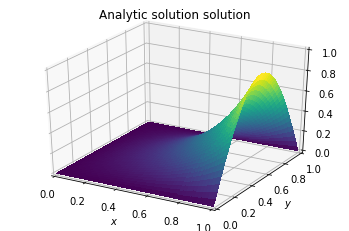

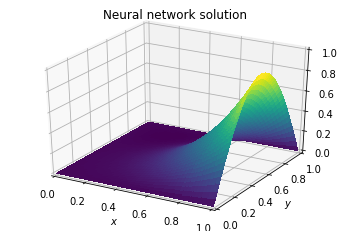

In [27]:
x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)
def analytic_solution(x):
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * \
    		np.sin(np.pi * x[0]) * (np.exp(np.pi * x[1]) - np.exp(-np.pi * x[1]))
surface = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

plt.title("Analytic solution solution")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');


x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)
def A(x):
    return x[1] * np.sin(np.pi * x[0])


def psy_trial(x, net_out):
    return A(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out

surface1 = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface1[i][j] = psy_trial((x,y), model(np.array([x,y]).reshape(1,2))[0][0].numpy())
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface1, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

plt.title("Neural network solution")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [40]:
model(np.array([x,y]).reshape(1,2))

<tf.Tensor: id=171237, shape=(1, 1), dtype=float32, numpy=array([[0.16467014]], dtype=float32)>

In [41]:
for i, x in enumerate(xx):
    for j, y in enumerate(yy):
        print(model(np.array([x,y]).reshape(1,2))[0][0].numpy())

0.0016467011
0.010520589
0.019244775
0.027968958
0.036729947
0.045525137
0.054320313
0.06311549
0.07191068
0.08070586
0.08950104
0.09829621
0.10709141
0.11588657
0.124681756
0.13347694
0.14227213
0.15106732
0.15986249
0.16865766
0.17745286
0.18624803
0.19504319
0.2038384
0.2126336
0.22142877
0.23022394
0.23901916
0.24781434
0.2566095
0.26540467
0.27419984
0.28299505
0.2917902
0.3005854
0.3093806
0.31817576
0.32697096
0.33576614
0.34456134
0.35335648
0.36215165
0.37094682
0.37974203
0.38853717
0.39733243
0.40612757
0.41492277
0.42371792
0.43251312
-0.006778405
0.008334325
0.017816186
0.02654037
0.03526455
0.043988742
0.05271293
0.061437108
0.0701613
0.07888548
0.08760966
0.09633386
0.10505803
0.11378221
0.12250641
0.1312306
0.13995478
0.14867896
0.15740316
0.16615424
0.17494941
0.18374461
0.19253975
0.20133492
0.21013016
0.2189253
0.22772048
0.23651567
0.24531087
0.25410604
0.26290122
0.2716964
0.2804916
0.2892868
0.29808196
0.30687714
0.31567234
0.32446754
0.33326268
0.34205785
0.35085